# Routing

Optical and high-speed RF ports have orientation requirements to avoid sharp turns, which can cause signal reflections.

GDSFactory offers:

- `route_single`: Routes a single connection between two ports.
- `route_bundle`: Routes multiple connections between two port groups using a bundle/river/bus router. It also accommodates waypoints and routing steps.

The most versatile function is `route_bundle`, as it handles both single and grouped routes.

In [ ]:
import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.port import Port

In [ ]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
c

## route_single

`route_single` returns a Manhattan route between 2 ports. A Manhattan route is a path between two points that is made up of only horizontal and vertical segments, with all turns being 90-degree angles.

In [ ]:
help(gf.routing.route_single)

In [ ]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.route_single(
    c,
    port1=mmi1.ports["o2"],
    port2=mmi2.ports["o1"],
    cross_section=gf.cross_section.strip,
)
c

In [ ]:
c.show()

⚠️ **Note:** You can also get the route length, but keep the following in mind: That route length is in **DBU** (Database Units). Usually, **1 DBU = 1 nm**.  

In [ ]:
print(f"route length = {route.length} DBU, {route.length/1000} um")

In [ ]:
route_length = 0
for instance in route.instances:
    route_length += instance.cell.info['length']

print(f"total route length = {route_length} um")

In [ ]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.route_single(
    c, port1=mmi1.ports["o2"], port2=mmi2.ports["o1"], layer=(1, 0), route_width=2
)
c

**Problem**: route_single with obstacles

Sometimes there are obstacles that the connect strip does not see!

In [ ]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))
x = c << gf.components.cross(length=20)
x.move((135, 20))
route = gf.routing.route_single(
    c, mmi1.ports["o2"], mmi2.ports["o2"], cross_section="strip"
)
c

**Solution**: specify the route steps

`route_single` allows you to define relative or absolute steps `x` or `y` for the route as well as with increments `dx` or `dy`.

In [ ]:
c = gf.Component()
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.route_single(
    c,
    port1=port1,
    port2=port2,
    cross_section="strip",

    # This provides a list of explicit waypoints (x, y coordinates) for the router. Instead of finding a path automatically,
    # the router is forced to create a Manhattan route that passes through each of these points in sequence.
    # This gives the user full, manual control over the waveguide's path.
    steps=[
        {"x": 20, "y": 0},
        {"x": 20, "y": 20},
        {"x": 120, "y": 20},
        {"x": 120, "y": 80},
    ],
)
c

In [ ]:
c = gf.Component()
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.route_single(
    c,
    port1=port1,
    port2=port2,
    cross_section="strip",
    steps=[
        {"x": 20},
        {"y": 20},
        {"x": 120},
        {"y": 80},
    ],
)
c

## route_bundle

To route groups of ports avoiding routing collisions between each route, you should use `route_bundle` instead of `route_single`.

`route_bundle` uses a river/bundle/bus router.

At the moment it works only when each group of ports has the same orientation.


In [ ]:
ys_right = [0, 10, 20, 40, 50, 80] # This line creates a list of six explicit y-coordinates for the right-side ports.
pitch = 127.0 # Defines the constant vertical distance for the left side ports.
N = len(ys_right) # This defines the total number of ports in each column (N, which is 6).

# This line uses a list comprehension to calculate six y-coordinates for the left-side ports.
# The formula (i - N / 2) * pitch ensures that the ports are evenly spaced by 127.0 µm and are centered vertically around y=0.
ys_left = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=gf.get_layer(layer))
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-200, ys_left[i]), width=0.5, orientation=0, layer=gf.get_layer(layer))
    for i in range(N)
]

# You can also mess up the port order and it will sort them by default.
left_ports.reverse()

c = gf.Component()
routes = gf.routing.route_bundle(
    c,
    left_ports,
    right_ports,
    start_straight_length=50,
    sort_ports=True,
    cross_section="strip",
)
c.add_ports(left_ports)
c.add_ports(right_ports)
c

In [ ]:
xs_top = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(xs_top)
xs_bottom = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

top_ports = [
    gf.Port(f"top_{i}", center=(xs_top[i], 0), width=0.5, orientation=270, layer=gf.get_layer(layer))
    for i in range(N)
]

bot_ports = [
    gf.Port(
        f"bot_{i}",
        center=(xs_bottom[i], -300),
        width=0.5,
        orientation=90,
        layer=gf.get_layer(layer),
    )
    for i in range(N)
]

c = gf.Component()
routes = gf.routing.route_bundle(
    c,
    top_ports,
    bot_ports,
    separation=5.0,
    end_straight_length=100,
    cross_section="strip",
)
c

`route_bundle` can also route bundles through corners:


In [ ]:

# The ports are grouped by quadrant: Top-Right (TR), Top-Left (TL), Bottom-Right (BR), and Bottom-Left (BL).
# Ports_A: These are groups of N ports arranged in vertical lines on the left and right sides of the component.
# Their orientation is either 0 (facing right) or 180 (facing left).
# Ports_B: These are groups of N ports arranged in horizontal lines on the top and bottom of the component.
# Their orientation is either 90 (facing up) or 270 (facing down).
@gf.cell(cache={})
def test_connect_corner(N=6, config="A"):
    d = 10.0
    sep = 5.0
    c = gf.Component()
    layer = (1, 0)

    if config in ["A", "B"]:
        a = 100.0
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(d, a / 2 + i * sep), # d, sep: Geometric values defining the distance and separation between ports.
                width=0.5,
                orientation=0,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-d, a / 2 + i * sep),
                width=0.5,
                orientation=180,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(d, -a / 2 - i * sep),
                width=0.5,
                orientation=0,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-d, -a / 2 - i * sep),
                width=0.5,
                orientation=180,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(a / 2 + i * sep, d),
                width=0.5,
                orientation=90,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-a / 2 - i * sep, d),
                width=0.5,
                orientation=90,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(a / 2 + i * sep, -d),
                width=0.5,
                orientation=270,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-a / 2 - i * sep, -d),
                width=0.5,
                orientation=270,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    elif config in ["C", "D"]:
        a = N * sep + 2 * d
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(a, d + i * sep),
                width=0.5,
                orientation=0,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-a, d + i * sep),
                width=0.5,
                orientation=180,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(a, -d - i * sep),
                width=0.5,
                orientation=0,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-a, -d - i * sep),
                width=0.5,
                orientation=180,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(d + i * sep, a),
                width=0.5,
                orientation=90,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-d - i * sep, a),
                width=0.5,
                orientation=90,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(d + i * sep, -a),
                width=0.5,
                orientation=270,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-d - i * sep, -a),
                width=0.5,
                orientation=270,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    # This loop iterates through the corresponding groups of ports from sets A and B
    # (e.g., it pairs ports_A_TR with ports_B_TR, then ports_A_TL with ports_B_TL.
    if config in ["A", "C"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            gf.routing.route_bundle(
                c, ports1, ports2, radius=5, sort_ports=True, cross_section="strip"
            )

    elif config in ["B", "D"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            gf.routing.route_bundle(
                c, ports2, ports1, radius=5, sort_ports=True, cross_section="strip"
            )

    return c


c = test_connect_corner(config="A")
c

In [ ]:
c = test_connect_corner(config="C")
c

In [ ]:
@gf.cell(cache={})

# dy=200: This defines the distance or separation between the two groups of ports.
def test_connect_bundle_udirect(dy=200, orientation=270, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35, 24, 0] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [70 + i * pitch for i in range(N)]

    # This determines the layout:
    # If the orientation is horizontal (0° or 180°), the separation dy will be along the X-axis.
    # If the orientation is vertical (90° or 270°), the separation dy will be along the Y-axis.
    # ports1 are created in a vertical line where x=0 and y coordinates are taken from the uneven xs1 list.
    # ports2 are created in a parallel vertical line where x=dy (shifted by 200) and y coordinates are from the evenly spaced xs2 list.
    # This results in two vertical lines of ports which are separated horizontally.
    if axis == "X":
        ports1 = [
            Port(
                f"top_{i}",
                center=(0, xs1[i]),
                width=0.5,
                orientation=orientation,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=orientation,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(
                f"top_{i}",
                center=(xs1[i], 0),
                width=0.5,
                orientation=orientation,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=orientation,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

    c = Component()
    gf.routing.route_bundle(
        c, ports1, ports2, radius=10.0, sort_ports=True, cross_section="strip"
    )
    return c


c = test_connect_bundle_udirect()
c

In [ ]:
@gf.cell
def test_connect_bundle_u_indirect(dy=-200, orientation=180, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [50 + i * pitch for i in range(N)]

    a1 = orientation
    a2 = a1 + 180

    if axis == "X":
        ports1 = [
            Port(f"top_{i}", center=(0, xs1[i]), width=0.5, orientation=a1, layer=gf.get_layer(layer))
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=a2,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=gf.get_layer(layer))
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=a2,
                layer=gf.get_layer(layer),
            )
            for i in range(N)
        ]

    c = Component()
    gf.routing.route_bundle(
        c,
        ports1,
        ports2,
        bend=gf.components.bend_euler,
        radius=5,
        cross_section="strip",
    )

    return c


c = test_connect_bundle_u_indirect(orientation=0)
c

In [ ]:
@gf.cell
def test_north_to_south(layer=(1, 0)):
    dy = 200.0
    xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

    pitch = 10.0
    N = len(xs1)
    xs2 = [-20 + i * pitch for i in range(N // 2)]
    xs2 += [400 + i * pitch for i in range(N // 2)]

    a1 = 90
    a2 = a1 + 180

    ports1 = [
        gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=gf.get_layer(layer))
        for i in range(N)
    ]

    ports2 = [
        gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=gf.get_layer(layer))
        for i in range(N)
    ]

    c = gf.Component()
    gf.routing.route_bundle(c, ports1, ports2, cross_section="strip")
    return c


c = test_north_to_south()
c

In [ ]:
@gf.cell
def demo_connect_bundle():
    """Combines all the connect_bundle tests."""
    y = 400.0
    x = 500
    y0 = 900
    dy = 200.0
    c = gf.Component()
    for j, s in enumerate([-1, 1]):
        for i, orientation in enumerate([0, 90, 180, 270]):
            ref = c << test_connect_bundle_u_indirect(
                dy=s * dy, orientation=orientation
            )
            ref.dcenter = (i * x, j * y)

            ref = c << test_connect_bundle_udirect(dy=s * dy, orientation=orientation)
            ref.dcenter = (i * x, j * y + y0)

    for i, config in enumerate(["A", "B", "C", "D"]):
        ref = c << test_connect_corner(config=config)
        ref.dcenter = (i * x, 1700)

    return c


c = demo_connect_bundle()
c.show()
c

In [ ]:
import gdsfactory as gf

In [ ]:
c = gf.Component()
c1 = c << gf.components.mmi2x2()
c2 = c << gf.components.mmi2x2()

c2.move((100, 50))
routes = gf.routing.route_bundle(
    c,
    [c1.ports["o4"], c1.ports["o3"]],
    [c2.ports["o1"], c2.ports["o2"]],
    radius=5,
    cross_section="strip",
)
c

In [ ]:
c = gf.Component()
c1 = c << gf.components.pad()
c2 = c << gf.components.pad()
c2.move((200, 100))
routes = gf.routing.route_bundle_electrical(
    c,
    [c1.ports["e3"]],
    [c2.ports["e1"]],
    cross_section=gf.cross_section.metal3,
)
c

**Problem**

Sometimes 90 degrees routes do not have enough space for a Manhattan route.

In [ ]:
c = gf.Component()
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
c

In [ ]:
c = gf.Component()
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.route_bundle(
    c,
    list(c1.ports.filter(orientation=0)),
    list(c2.ports.filter(orientation=180)),
    on_collision=None,
    cross_section="strip",
)
c

In [ ]:
c = gf.Component()
pitch = 2.0
ys_left = [0, 10, 20]
N = len(ys_left)
ys_right = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=gf.get_layer(layer))
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-50, ys_left[i]), width=0.5, orientation=0, layer=gf.get_layer(layer))
    for i in range(N)
]

# This reverses the order of the items in the list named left_ports in-place.
# For example, if left_ports was [port_A, port_B, port_C], after this line it would become [port_C, port_B, port_A].
# on_collision=None: This tells the router how to handle cases where waveguides might overlap or run into other geometry.
# By setting it to None, the router will simply ignore any collisions.
left_ports.reverse()
routes = gf.routing.route_bundle(
    c, right_ports, left_ports, radius=5, on_collision=None, cross_section="strip"
)

c

**Solution**

Add S-bend routes using `route_bundle_sbend`.

In [ ]:
c = gf.Component()
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.route_bundle_sbend(
    c,
    c1.ports.filter(orientation=0),
    c2.ports.filter(orientation=180),
    enforce_port_ordering=False,
)
c

In [ ]:
import gdsfactory as gf
from gdsfactory.samples.big_device import big_device

c = gf.Component()
c1 = big_device()
c2 = gf.routing.add_fiber_array(c1)
c2.plot()

In [ ]:
c = gf.Component()
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.route_bundle(
    c,
    [port1],
    [port2],
    cross_section="strip",
    steps=[
        {"dy": 30, "dx": 50},
        {"dx": 100},
    ],
)
c

In [ ]:
c = gf.Component()
w = gf.components.array(gf.c.straight, columns=1, rows=3, row_pitch=3)
left = c << w
right = c << w
right.move((100, 100))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 35

ports1 = left.ports.filter(orientation=0)
ports2 = right.ports.filter(orientation=180)

routes = gf.routing.route_bundle(
    c,
    ports1,
    ports2,
    cross_section="strip",
    sort_ports=True,
    steps=[
        {"dy": 30, "dx": 50},
        {"dx": 90},
    ],
)
c

### Path length matching

By supplying a `PathLengthConfig` dict, path length matching can be achieved. The returned routes can report their path length in dbu.

PathLengthConfig and its enums are defined as follows:

In [7]:
from IPython.display import Markdown, display
import inspect

def show_code(func):
    code = inspect.getsource(func)
    display(Markdown(f"```python\n{code}\n```"))

In [10]:
show_code(gf.routing.PathLengthConfig)

```python
class PathLengthConfig(TypedDict, total=False):
    loops: int
    loop_side: int
    element: int
    loop_position: int

```

In [11]:
show_code(gf.routing.LoopSide)

```python
class LoopSide(IntEnum):
    left = -1
    center = 0
    right = 1

```

In [12]:
show_code(gf.routing.LoopPosition)

```python
class LoopPosition(IntEnum):
    start = -1
    center = 0
    end = 1

```

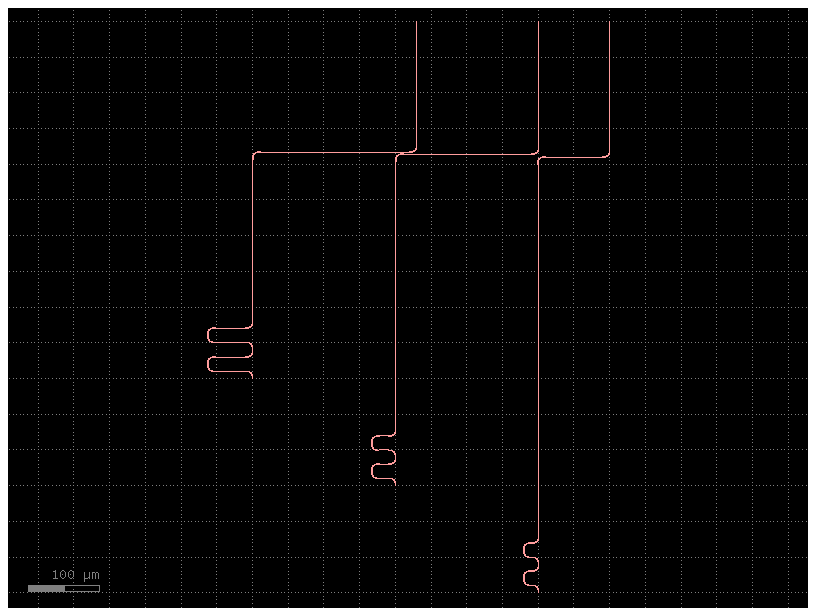

In [13]:
# Position the path matching at the start of the first element and adjust the loops to all be on the left side of the route (start port to finish)
xs = gf.get_cross_section("strip")

start_ports = [
    gf.Port(
        center=(i * 200,-i * 150),
        orientation = 90,
        layer=gf.get_layer(xs.sections[0].layer),width=.5,
    )
    for i in range(3)
]
end_ports = [
    gf.Port(
        center=(x,500),orientation=270,layer=gf.get_layer(xs.sections[0].layer), width=0.5,
    )
    for x in [230, 400, 500]
]

c = gf.Component()
gf.routing.route_bundle(
    c,
    start_ports,
    end_ports,
    start_straight_length=300,
    cross_section="strip",
    path_length_matching_config={"element": 0, "loop_side":gf.routing.LoopSide.left, "loops": 2, "loop_position": gf.routing.LoopPosition.start}
)

c.plot()

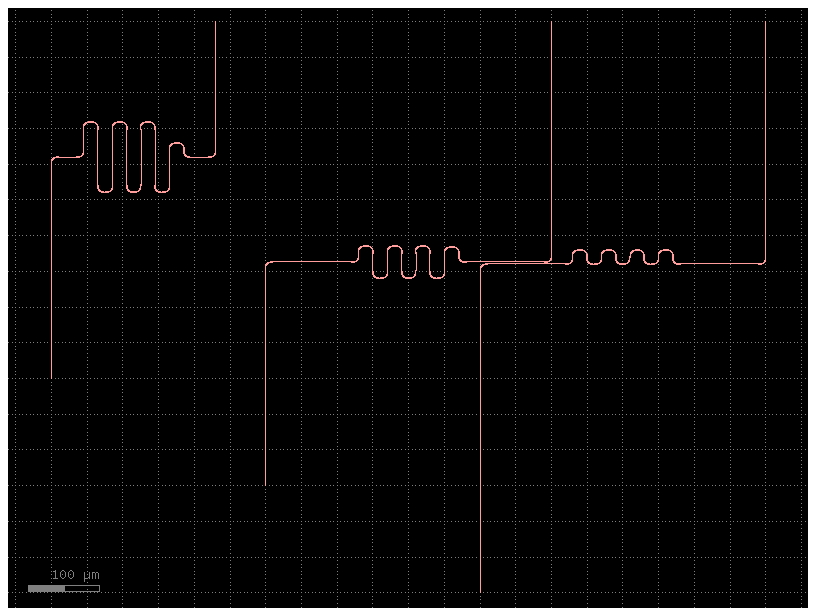

In [17]:
# Position the path matching at the middle of the second element and adjust the loops to all be on the center of the route (start port to finish)
xs = gf.get_cross_section("strip")

start_ports = [
    gf.Port(
        center=(i * 300,-i * 150),
        orientation = 90,
        layer=gf.get_layer(xs.sections[0].layer),width=.5,
    )
    for i in range(3)
]
end_ports = [
    gf.Port(
        center=(x,500),orientation=270,layer=gf.get_layer(xs.sections[0].layer), width=0.5,
    )
    for x in [230, 700, 1000]
]

c = gf.Component()
gf.routing.route_bundle(
    c,
    start_ports,
    end_ports,
    start_straight_length=300,
    cross_section="strip",
    path_length_matching_config={"element": 1, "loop_side":gf.routing.LoopSide.center, "loops": 2, "loop_position": gf.routing.LoopPosition.center}
)

c.plot()

In [ ]:
# Position the path matching at the end of the last element and adjust the loops to all be on the right si of the route (start port to finish)
xs = gf.get_cross_section("strip")

start_ports = [
    gf.Port(
        center=(i * 300,-i * 150),
        orientation = 90,
        layer=gf.get_layer(xs.sections[0].layer),width=.5,
    )
    for i in range(3)
]
end_ports = [
    gf.Port(
        center=(x,500),orientation=270,layer=gf.get_layer(xs.sections[0].layer), width=0.5,
    )
    for x in [230, 700, 1000]
]

c = gf.Component()
gf.routing.route_bundle(
    c,
    start_ports,
    end_ports,
    start_straight_length=300,
    cross_section="strip",
    path_length_matching_config={"element": 1, "loop_side":gf.routing.LoopSide.center, "loops": 2, "loop_position": gf.routing.LoopPosition.center}
)

c.plot()

## route_astar

You can navigate around bounding boxes when routing if you pass the boxes of all the objects that you want to avoid.


If you want to navigate around all bounding boxes, you can also use the `route_astar` function.

In [ ]:
import gdsfactory as gf

c = gf.Component()
cross_section = "strip"
port_prefix = "o"
bend = gf.components.bend_euler

cross_section = gf.get_cross_section(cross_section, radius=5)
w = gf.components.straight(cross_section=cross_section)
left = c << w
right = c << w
right.rotate(90)
right.move((168, 63))

obstacle = gf.components.rectangle(size=(250, 3), layer="M2")
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle3 = c << obstacle
obstacle4 = c << obstacle
obstacle4.rotate(90)
obstacle1.ymin = 50
obstacle1.xmin = -10
obstacle2.xmin = 35
obstacle3.ymin = 42
obstacle3.xmin = 72.23
obstacle4.xmin = 200
obstacle4.ymin = 55
port1 = left.ports[f"{port_prefix}1"]
port2 = right.ports[f"{port_prefix}2"]

# This gdsfactory function calculates a route for a waveguide using the A* algorithm,
# which is a popular pathfinding algorithm known for finding the shortest path between two points on a grid.
route = gf.routing.route_astar(
    component=c,
    port1=port1,
    port2=port2,
    cross_section=cross_section,

    # resolution=15: This parameter controls the grid size for the A* search algorithm. The router converts the component's layout into a grid,
    # and a value of 15 means the grid cells are 15 nanometers on each side (since gdsfactory's default unit is micrometers, this corresponds to 0.015 um).
    # A smaller resolution creates a finer grid, which can find more complex paths but takes longer to compute.
    resolution=15,
    distance=12,
    avoid_layers=("M2",),
    bend=bend,
)
c

In [ ]:
@gf.cell
def demo_route_astar_electrical() -> gf.Component:
    c = gf.Component()
    cross_section_name = "metal_routing"
    port_prefix = "e"
    bend = gf.components.wire_corner

    cross_section = gf.get_cross_section(cross_section_name)
    w = gf.components.straight(cross_section=cross_section)
    left = c << w
    right = c << w
    right.rotate(90)  # Type: ignore[arg-type]
    right.move((168, 63))

    obstacle = gf.components.rectangle(size=(250, 3), layer="M3")
    obstacle1 = c << obstacle
    obstacle2 = c << obstacle
    obstacle3 = c << obstacle
    obstacle4 = c << obstacle
    obstacle4.rotate(90)  # Type: ignore[arg-type]
    obstacle1.ymin = 50
    obstacle1.xmin = -10
    obstacle2.xmin = 35
    obstacle3.ymin = 42
    obstacle3.xmin = 72.23  # Type: ignore
    obstacle4.xmin = 200
    obstacle4.ymin = 55
    port1 = left.ports[f"{port_prefix}1"]
    port2 = right.ports[f"{port_prefix}2"]

    gf.routing.route_astar(
        component=c,
        port1=port1,
        port2=port2,
        cross_section=cross_section,
        resolution=10,
        distance=15,
        avoid_layers=("M3",),
        bend=bend,
    )
    return c

c = demo_route_astar_electrical()
c

## route_bundle with collisions


The route bundle also supports avoiding obstacles.

Currently the router only respects any (merged) bounding boxes which overlap with start or end port bundles.

In [ ]:
import gdsfactory as gf

c = gf.Component()
columns = 2
ptop = c << gf.components.pad_array(columns=columns, port_orientation=270)
pbot = c << gf.components.pad_array(port_orientation=270, columns=columns)
ptop.movex(300)
ptop.movey(300)

obstacle = c << gf.c.rectangle(size=(300, 100), layer="M3")
obstacle.ymin = pbot.ymax - 10
obstacle.xmin = pbot.xmax - 10


routes = gf.routing.route_bundle_electrical(
    c,
    pbot.ports,
    ptop.ports,
    start_straight_length=100,
    separation=20,
    cross_section="metal_routing",
    bboxes=[
        obstacle.bbox(),
        pbot.bbox(),
        ptop.bbox(),
    ],  # Obstacles to avoid need to be touching the initial or end ports.
    sort_ports=True,
)

c

If the obstacle does not intersect the initial or end ports, the router does not attempt to avoid it.

In [ ]:
import gdsfactory as gf

c = gf.Component()
columns = 2
ptop = c << gf.components.pad_array(columns=columns, port_orientation=270)
pbot = c << gf.components.pad_array(port_orientation=270, columns=columns)
ptop.movex(300)
ptop.movey(300)

obstacle = c << gf.c.rectangle(size=(300, 100), layer="M3", centered=True)
obstacle.ymin = pbot.ymax - 10
obstacle.xmin = pbot.xmax + 10


routes = gf.routing.route_bundle_electrical(
    c,
    pbot.ports,
    ptop.ports,
    start_straight_length=100,
    separation=20,
    cross_section="metal_routing",
    bboxes=[
        obstacle.bbox(), 
        pbot.bbox(),
        ptop.bbox(),
    ],  
    sort_ports=True,
)

c

However you can make it larger in order to set an obstacle it needs to avoid.

In [ ]:
import gdsfactory as gf

c = gf.Component()
columns = 2
ptop = c << gf.components.pad_array(columns=columns, port_orientation=270)
pbot = c << gf.components.pad_array(port_orientation=270, columns=columns)
ptop.movex(300)
ptop.movey(300)

obstacle = c << gf.c.rectangle(size=(300, 100), layer="M3", centered=True)
obstacle.ymin = pbot.ymax - 10
obstacle.xmin = pbot.xmax + 10


routes = gf.routing.route_bundle_electrical(
    c,
    pbot.ports,
    ptop.ports,
    start_straight_length=100,
    separation=20,
    cross_section="metal_routing",
    bboxes=[
        obstacle.bbox().enlarge(10), # Otherwise you need to enlarge the bbox by 10 um.
        pbot.bbox(),
        ptop.bbox(),
    ],  
    sort_ports=True,
)

c

## route_bundle_all_angle

You can also route using diagonal routes.

In [ ]:
import gdsfactory as gf

c = gf.Component()
rows = 3
straight = gf.c.straight
w1 = c << gf.c.array(straight, rows=rows, columns=1, row_pitch=10)
w2 = c << gf.c.array(straight, rows=rows, columns=1, row_pitch=10)
w2.rotate(-30)
w2.movex(140)
p1 = list(w1.ports.filter(orientation=0))
p2 = list(w2.ports.filter(orientation=150))
p1.reverse()
p2.reverse()

gf.routing.route_bundle_all_angle(
    c,
    p1,
    p2,
    separation=3,
)
c

You can also use it to connect rotated components that do not have a manhattan orientation (0, 90, 180, 270).

In [ ]:
c = gf.Component()

mmi = gf.components.mmi2x2(width_mmi=10, gap_mmi=3)
mmi1 = c.add_ref_off_grid(mmi)  # Create a virtual instance.
mmi2 = c.add_ref_off_grid(mmi)  # Create a virtual instance.

mmi2.move((100, 10))
mmi2.rotate(30)

routes = gf.routing.route_bundle_all_angle(
    c,
    mmi1.ports.filter(orientation=0),
    [mmi2.ports["o2"], mmi2.ports["o1"]],
)
c.show()
c

## Dubins paths

If you are looking for a straightforward way to optimize waveguide paths, Dubins paths (named after Lester Eli Dubins) offer an effective solution by ensuring the shortest path with minimal bending and loss.

Using Dubins paths for waveguide routing can simplify your design process significantly.
Compared to traditional interconnects, Dubins paths offer shorter, more reliable routes that avoid unnecessary bending and intersections.
This translates into denser, cleaner designs with improved performance.

[See blog](https://quentinwach.com/blog/2024/02/15/dubins-paths-for-waveguide-routing.html)

In [ ]:
c = gf.Component()

# Create two straight waveguides with different orientations.
wg1 = c << gf.components.straight(length=100, width=3.2)
wg2 = c << gf.components.straight(length=100, width=3.2)

# Move and rotate the second waveguide.
wg2.move((300, 50))
wg2.rotate(45)

# Route between the output of wg1 and input of wg2.
route = gf.routing.route_dubins(
    c,
    port1=wg1.ports["o2"],
    port2=wg2.ports["o1"],
    cross_section=gf.cross_section.strip(width=3.2, radius=100),
)
c

In [ ]:
c = gf.Component()

# Create two multi-port components.
comp1 = c << gf.components.nxn(west=0, east=10, xsize=10, ysize=100, wg_width=3.2)
comp2 = c << gf.components.nxn(west=0, east=10, xsize=10, ysize=100, wg_width=3.2)

# Position the second component.
comp2.rotate(30)
comp2.move((500, -100))

# Route between corresponding ports.
for i in range(10):
    port1_name = f"o{10-i}"  # Inverted port id for port1.
    port2_name = f"o{i+1}"  # Adjusted to match available ports.
    gf.routing.route_dubins(
        c,
        port1=comp1.ports[port1_name],
        port2=comp2.ports[port2_name],
        cross_section=gf.cross_section.strip(width=3.2, radius=100 + i * 10),
    )
c

## auto_taper

Both `route_single` and `route_bundle` have a `auto_taper` parameter. 

For auto_taper to work you need to define how to transition between different layers and widths. Another option is to explicitly pass the `auto_taper_taper` parameter to `route_bundle`.
See examples in the next section.

```python

layer_transitions = {
    LAYER.WG: partial(gf.c.taper, cross_section="strip", length=10),
    (LAYER.WG, LAYER.WGN): "taper_sc_nc",
    (LAYER.WGN, LAYER.WG): "taper_nc_sc",
    LAYER.M3: "taper_electrical",
}

return Pdk(
    name="generic",
    cells=cells,
    cross_sections=cross_sections,
    layers=LAYER,
    layer_stack=LAYER_STACK,
    layer_views=LAYER_VIEWS,
    layer_transitions=layer_transitions,
    materials_index=materials_index,
    constants=constants,
    connectivity=LAYER_CONNECTIVITY,
)

```

As seen in the code below: 
If you have a width mismatch between two ports, the router will automatically add a taper to transition between the two widths, only if `auto_taper=True`, otherwise it will raise an error.


In [ ]:
c = gf.Component()
s1 = c << gf.components.straight()
s2 = c << gf.components.straight(width=2)
s2.move((40, 50))
route = gf.routing.route_single(
    c,
    port1=s1.ports["o2"],
    port2=s2.ports["o1"],
    cross_section="strip",
    auto_taper=True,
)
c

In [ ]:
import gdsfactory as gf
from gdsfactory.routing.auto_taper import auto_taper_to_cross_section


@gf.cell
def silicon_nitride_strip(width_nitride: float = 1) -> gf.Component:
    c = gf.Component()
    ref = c << gf.c.straight(
        cross_section=gf.cross_section.nitride, width=width_nitride
    )
    port1 = auto_taper_to_cross_section(
        c, port=ref["o1"], cross_section=gf.cross_section.strip
    )
    c.add_port(name="o1", port=port1)
    c.add_port(name="o2", port=ref["o2"])
    return c


c = silicon_nitride_strip(width_nitride=1)
c

In [ ]:
c = silicon_nitride_strip(width_nitride=4)
c

## route_bundle with tapers

You can automatically taper the routes to match the width of the ports of the route width cross_section.

In [ ]:
c = gf.Component()
s1 = c << gf.components.straight(width=4)
s2 = c << gf.components.straight(width=4)
s2.move((100, 50))
route = gf.routing.route_bundle(
    c, [s1.ports["o2"]], [s2.ports["o1"]], auto_taper=True, cross_section="strip"
)
c

You can also pass a particular taper to the route_bundle function to automatically add tapers to the routes when needed:

In [ ]:
c = gf.Component()
s1 = c << gf.components.straight(width=4)
s2 = c << gf.components.straight(width=4)
s2.move((100, 50))
route = gf.routing.route_bundle(
    c, [s1.ports["o2"]], [s2.ports["o1"]], auto_taper=True, cross_section="strip", auto_taper_taper=gf.components.taper(width1=4, width2=0.5, length=30)
)
c

## route_bundle with low loss

You can taper to wider widths to reduce the propagation loss, as wider widths have lower loss.

In [ ]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.route_bundle(
    c, [mmi1.ports["o2"]], [mmi2.ports["o1"]], taper=gf.components.taper(width1=0.5, width2=2), cross_section="strip", min_straight_taper=20,
)
c